In [1]:
import json
import pandas as pd
import seaborn as sns
from hs_fetch.fast_fetch.fast_fetch_interactive_input import FetchMode
from hs_fetch.fast_fetch.fast_fetch_persistor import FastFetchPersistor, ESIndexSuffix
from hs_fetch.fast_fetch.refactored.fetch_evaluator import FetchEvaluator
from hs_fetch.fast_fetch.refactored.fetch_classifier import FetchClassifier
from hs_fetch.fast_fetch.refactored.fetch_data_adapter import get_data_adapter
from hs_fetch.fast_fetch.refactored.fetch_feature_extractor import FetchFeatureExtractor
from hs_fetch.fast_fetch.refactored.fetch_result_builder import FetchResultBuilder
from hs_gimme.constants.clients import ClientsNames
from hs_gimme.env_utils.env_utils import get_current_environment
from hs_gimme.logging_service.logging_service import LoggingService
from hs_tree_blenders_creation.batch_runners.data_sets import get_account_test_set

2023-07-20T11:21:56.261727Z [info     ] Explainable job type: loaded aliases to job types environment=local file_path=/Users/dima/hiredscore/grading/algorithms/hs_algorithms/explainable_job_type/explainable_job_type.py function_name=load_job_type_data hostname=Dima-Shulga-MacBook-Pro line_number=109 module=hs_algorithms.explainable_job_type.explainable_job_type num_aliases__numeric=365 num_job_types__numeric=214 pid=3859
2023-07-20T11:21:56.403686Z [info     ] Read abbreviation sets         environment=local file_path=/Users/dima/hiredscore/grading/algorithms/hs_algorithms/abbreviations/abbrevations_provider.py function_name=_get_abbreavations_from_file hostname=Dima-Shulga-MacBook-Pro line_number=34 module=hs_algorithms.abbreviations.abbrevations_provider num_terms__numeric=91 pid=3859


/Users/dima/.virtualenvs/hs/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
ACCOUNT_ID = 'indiana'
ENVIRONMENT = 'production'
logging_service = LoggingService()

In [3]:
persistor = FastFetchPersistor(logging_service=logging_service, account_id=ACCOUNT_ID, environment=ENVIRONMENT, index_suffix=ESIndexSuffix.ACTIVE)
data_adapter = get_data_adapter(ACCOUNT_ID, ENVIRONMENT, logging_service)
extractor = FetchFeatureExtractor(calc_fetch_apply_prob=True, 
                                  specific_features_names=None, 
                                  specific_features_weights=None, 
                                  fetch_mode=FetchMode.TALENT_FETCH,
                                  search_input=None, 
                                  account_id=ACCOUNT_ID, 
                                  fetch_config=None, 
                                  reference_date=None)
classifier = FetchClassifier()

Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials


In [4]:
df = pd.read_csv('fetch_data.csv')
len(df)

42

In [5]:
df.head()

,req_id,talent_id,label
0,INTJR0129214,dbdf5c58-ac07-4ca2-ae96-e256215da3b4,False
1,INTJR0129214,a09d5068-4d41-41d6-a185-9a2c27671723,True
2,INTJR0129214,cbb9a75d-5b71-459a-945a-c78bf470940c,False
3,INTJR0157698,268643b2-909b-4058-b2a6-584fd7240a7d,False
4,INTJR0157698,5c87ea87-ceb0-4e8d-96c7-e1d40d8e75de,False


In [6]:
df['candidate_data'] = df['talent_id'].apply(lambda c: persistor.get_candidate_data_by_talent_ids([c])[0])

In [8]:
df['req_data'] = df['req_id'].apply(lambda r: data_adapter.get_req_data(r)[0])

In [9]:
df.head()

,req_id,talent_id,label,candidate_data,req_data
0,INTJR0129214,dbdf5c58-ac07-4ca2-ae96-e256215da3b4,False,"{'id': 'grading_candidate_INTCA01720801', 'can...","{'id': 'grading_req_INTJR0129214', 'req_id': '..."
1,INTJR0129214,a09d5068-4d41-41d6-a185-9a2c27671723,True,{'id': 'grading_candidate_limsitliang@gmail.co...,"{'id': 'grading_req_INTJR0129214', 'req_id': '..."
2,INTJR0129214,cbb9a75d-5b71-459a-945a-c78bf470940c,False,"{'id': 'grading_candidate_wnaing@gmail.com', '...","{'id': 'grading_req_INTJR0129214', 'req_id': '..."
3,INTJR0157698,268643b2-909b-4058-b2a6-584fd7240a7d,False,{'id': 'grading_candidate_fadihanhan96@gmail.c...,"{'id': 'grading_req_INTJR0157698', 'req_id': '..."
4,INTJR0157698,5c87ea87-ceb0-4e8d-96c7-e1d40d8e75de,False,"{'id': 'grading_candidate_INTCA02197785', 'can...","{'id': 'grading_req_INTJR0157698', 'req_id': '..."


In [10]:
dfs = []
            
for req_id, req_df in df.groupby('req_id'):
    req = req_df['req_data'].iloc[0]
    candidates_data = list(req_df['candidate_data'])
    req_items, candidate_items = data_adapter.get_grading_data([req], candidates_data)

    features = extractor.extract_features(candidates_data, req_items[0], {})
    
    for feature_name, feature_values in features.items():
        req_df[feature_name] = feature_values

    dfs.append(req_df)
    
features_df = pd.concat(dfs).reset_index(drop=True)
features_df.shape

2023-07-20T11:22:44.387275Z [info     ] Getting model reader           environment=local file_path=/Users/dima/hiredscore/brain/brainme/hs_brainme/models/model_persistence/models_persistency.py function_name=get_model_reader hostname=Dima-Shulga-MacBook-Pro line_number=82 model_key=None model_manager=hs_neurons model_name=experience_total_matching model_type=torch models_reader=LocalTorchModelsReader module=hs_brainme.models.model_persistence.models_persistency pid=3859
2023-07-20T11:22:44.389175Z [info     ] Loading model file             compressed__boolean=False dir=/Users/dima/hiredscore_model_manager/hs_neurons/experience_total_matching/experience_total_matching_20221130101127 environment=local file_name=/Users/dima/hiredscore_model_manager/hs_neurons/experience_total_matching/experience_total_matching_20221130101127/key.torch file_path=/Users/dima/hiredscore/brain/brainme/hs_brainme/models/model_persistence/models_persistency.py function_name=load hostname=Dima-Shulga-MacBook-Pro

/Users/dima/.virtualenvs/hs/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(42, 22)

In [11]:
features_df.head()

,req_id,talent_id,label,candidate_data,req_data,skills_w2v,titles_w2v,skills_by_importance,professions_match,profession_years_grade,...,high_degree_level_grade,high_past_status_grade,model_score,time_in_position,level_score,skill_score,performance_model,seniority_grade,future_apply_grade,majors_grade
0,INTJR0006847,ec4a1ee3-5a4b-4181-9afa-153dc9e33fc4,False,{'id': 'grading_candidate_ivan.ruiz.llamas@hot...,"{'id': 'grading_req_INTJR0006847', 'req_id': '...",0.557675,0.572806,None,0.863959,1.0,...,1.0,0.1,None,None,None,None,None,0.0,None,1.0
1,INTJR0006847,6b1bfeb2-a671-4238-bb74-52f20bd6f78c,True,{'id': 'grading_candidate_mantiniok0051@gmail....,"{'id': 'grading_req_INTJR0006847', 'req_id': '...",0.401848,0.514445,None,0.721469,1.0,...,1.0,0.1,None,None,None,None,None,0.0,None,1.0
2,INTJR0006847,d931c4a4-b35a-45c3-b97d-fabc349f9e91,False,{'id': 'grading_candidate_mstoutch@outlook.com...,"{'id': 'grading_req_INTJR0006847', 'req_id': '...",0.649868,0.679478,None,0.437605,1.0,...,1.0,0.1,None,None,None,None,None,0.0,None,1.0
3,INTJR0038683,5ab06533-b6d6-4014-b1d2-51208ab330f7,False,"{'id': 'grading_candidate_INTCA00442750', 'can...","{'id': 'grading_req_INTJR0038683', 'req_id': '...",0.439158,0.710950,0.0,0.819152,1.0,...,0.7,1.0,None,None,None,None,None,0.0,0.077532,1.0
4,INTJR0038683,5ab06533-b6d6-4014-b1d2-51208ab330f7,True,"{'id': 'grading_candidate_INTCA00442750', 'can...","{'id': 'grading_req_INTJR0038683', 'req_id': '...",0.439158,0.710950,0.0,0.819152,1.0,...,0.7,1.0,None,None,None,None,None,0.0,0.077532,1.0


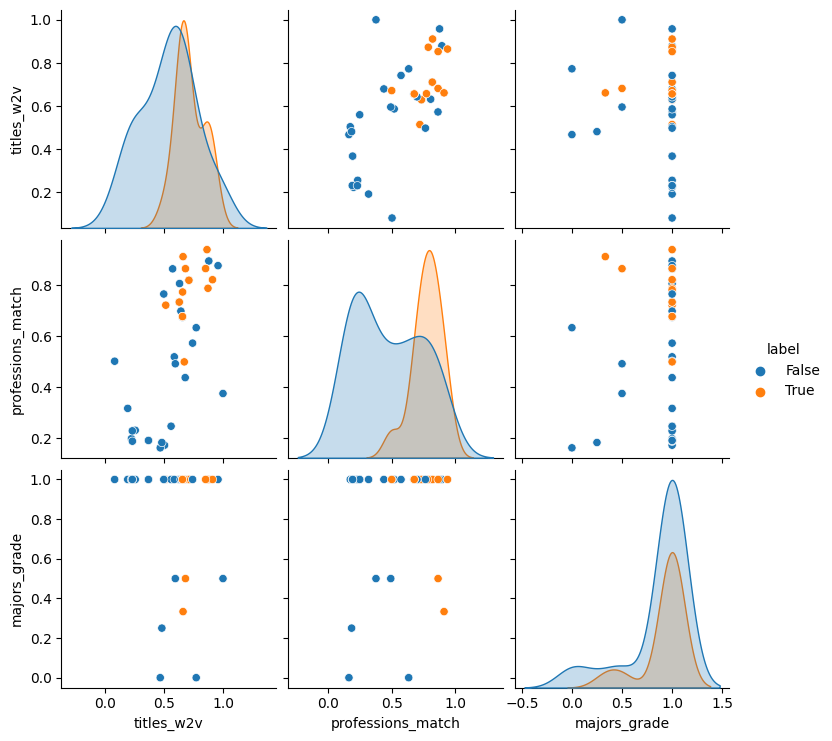

In [12]:
cols = ['skills_w2v', 'titles_w2v', 'professions_match', 'majors_grade', 'label']
sns.pairplot(data=features_df[cols], hue='label')

In [14]:
grades, initial_grades = classifier.predict_grades(features_df.to_dict(), len(features_df.to_dict()['skills_w2v']))

2023-07-20T11:23:21.626440Z [info     ] Getting model reader           environment=local file_path=/Users/dima/hiredscore/brain/brainme/hs_brainme/models/model_persistence/models_persistency.py function_name=get_model_reader hostname=Dima-Shulga-MacBook-Pro line_number=82 model_key=general model_manager=hs_algorithms model_name=fetch_grading model_type=pickle models_reader=LocalPickleModelsReader module=hs_brainme.models.model_persistence.models_persistency pid=3859
2023-07-20T11:23:21.627026Z [info     ] Loading model file             compressed__boolean=True dir=/Users/dima/hiredscore_model_manager/hs_algorithms/fetch_grading/general_20230511130355 environment=local file_name=/Users/dima/hiredscore_model_manager/hs_algorithms/fetch_grading/general_20230511130355/key.pickle file_path=/Users/dima/hiredscore/brain/brainme/hs_brainme/models/model_persistence/models_persistency.py function_name=load hostname=Dima-Shulga-MacBook-Pro key=key line_number=167 model_type=pickle module=hs_brain

In [15]:
features_df['grade'] = grades
features_df['initial_grades'] = initial_grades

In [18]:
features_df.head()

,req_id,talent_id,label,candidate_data,req_data,skills_w2v,titles_w2v,skills_by_importance,professions_match,profession_years_grade,...,model_score,time_in_position,level_score,skill_score,performance_model,seniority_grade,future_apply_grade,majors_grade,grade,initial_grades
0,INTJR0006847,ec4a1ee3-5a4b-4181-9afa-153dc9e33fc4,False,{'id': 'grading_candidate_ivan.ruiz.llamas@hot...,"{'id': 'grading_req_INTJR0006847', 'req_id': '...",0.557675,0.572806,None,0.863959,1.0,...,None,None,None,None,None,0.0,None,1.0,0.746462,0.545034
1,INTJR0006847,6b1bfeb2-a671-4238-bb74-52f20bd6f78c,True,{'id': 'grading_candidate_mantiniok0051@gmail....,"{'id': 'grading_req_INTJR0006847', 'req_id': '...",0.401848,0.514445,None,0.721469,1.0,...,None,None,None,None,None,0.0,None,1.0,0.499889,0.450111
2,INTJR0006847,d931c4a4-b35a-45c3-b97d-fabc349f9e91,False,{'id': 'grading_candidate_mstoutch@outlook.com...,"{'id': 'grading_req_INTJR0006847', 'req_id': '...",0.649868,0.679478,None,0.437605,1.0,...,None,None,None,None,None,0.0,None,1.0,0.055417,0.230481
3,INTJR0038683,5ab06533-b6d6-4014-b1d2-51208ab330f7,False,"{'id': 'grading_candidate_INTCA00442750', 'can...","{'id': 'grading_req_INTJR0038683', 'req_id': '...",0.439158,0.710950,0.0,0.819152,1.0,...,None,None,None,None,None,0.0,0.077532,1.0,0.718201,0.533114
4,INTJR0038683,5ab06533-b6d6-4014-b1d2-51208ab330f7,True,"{'id': 'grading_candidate_INTCA00442750', 'can...","{'id': 'grading_req_INTJR0038683', 'req_id': '...",0.439158,0.710950,0.0,0.819152,1.0,...,None,None,None,None,None,0.0,0.077532,1.0,0.718201,0.533114


/Users/dima/.virtualenvs/hs/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='professions_match', ylabel='grade'>

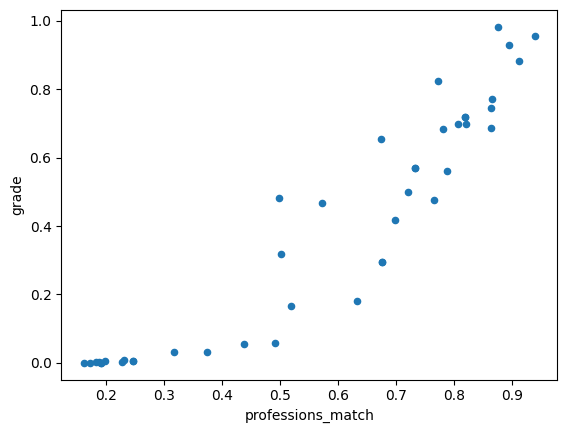

In [16]:
cols = ['skills_w2v', 'titles_w2v', 'professions_match', 'majors_grade', 'grade']
features_df.plot.scatter('professions_match', 'grade')

<Axes: xlabel='grade', ylabel='Count'>

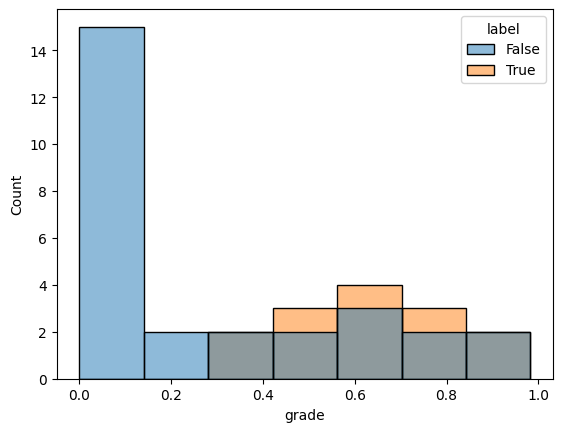

In [17]:
sns.histplot(data=features_df, x='grade', hue='label')